# Определение возраста покупателей

## Описание данных
Данные взяты с сайта [ChaLearn Looking at People](http://chalearnlap.cvc.uab.es/dataset/26/description/)

База данных APPA-REAL содержит 7591 изображение с соответствующими метками реального и видимого возраста. Общее количество голосов о видимом возрасте составляет около 250 000. В среднем по около 38 голосов на каждое изображение. Это делает средний видимый возраст очень стабильным (0,3 стандартное отклонение).

Изображения разделены на 3 выборки train (4113 изображений), valid (1500 изображений) и test (1978  изображений) разбитых по соответствующим папкам. Для каждого изображения X.jpg предоставлены соответствующие X.jpg_face.jpg, которые содержат обрезанное и повернутое лицо с 40%-ным запасом, полученным от детектора лиц [Mathias et. al](http://markusmathias.bitbucket.org/2014_eccv_face_detection/) при нескольких поворотах. Кроме того, предоставляется файл X.jpg.mat с метаинформацией об обнаруженном лице.

Реальный возраст и кажущиеся оценки возраста указаны в файлах gt_train.csv, gt_test.csv и gt_valid.csv, с отдельной строкой для каждой оценки.

Кроме того, мы предоставляем сводки по каждому изображению в gt_avg_train.csv, gt_avg_valid.csv и gt_avg_test.csv, показывающие количество оценок, средний видимый возраст, стандартное отклонение видимого возраста и реальный возраст для каждого изображения.

## Исследовательский анализ данных

In [12]:
# pip install tensorflow-gpu==2.10.0

In [13]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

if tf.test.is_built_with_cuda():
    print(' ## CUDA is available ## ', "\n")
    # print(tf.sysconfig.get_build_info(), "\n")
    sys_details = tf.sysconfig.get_build_info()
    print('Prescribed CUDA version:', sys_details["cuda_version"]) #static number, no depend on actual version
    print('Prescribed cuDNN version:', sys_details["cudnn_version"], "\n") #static number no depend on actual version
    print(tf.config.list_physical_devices('GPU')) #official recommendation to check GPU is enabled
else:
    print(' ## CUDA not availeble ## ')
    print(tf.reduce_sum(tf.random.normal([1000, 1000]))) #official recommendation to check CPU is enabled

print(device_lib.list_local_devices())


from PIL import Image

import matplotlib.pyplot as plt
plt.style.use('dark_background')

 ## CUDA is available ##  

Prescribed CUDA version: 64_112
Prescribed cuDNN version: 64_8 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5504565316611882436
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7043284992
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8398690289240337233
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:26:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [14]:
df_train = pd.read_csv('datasets\gt_avg_train.csv')
print('Размер обучающей выборки:', df_train.shape)
df_valid = pd.read_csv('datasets\gt_avg_valid.csv')
print('Размер валидационной выборки:', df_valid.shape)
df_test = pd.read_csv('datasets\gt_avg_test.csv')
print('Размер тестовой выборки:', df_test.shape)

Размер обучающей выборки: (4113, 5)
Размер валидационной выборки: (1500, 5)
Размер тестовой выборки: (1978, 5)


Объединим выборки в один датасет для анализа, а так же избавимся от лишних столбцов.
название файла преобразуем в путь к файлу, так как изображения лежат в разных папках. Кроме того добавим к имени файла суффикс `_face.jpg`, чтобы работать с уже предобработанными изображениями

In [15]:
df_train['file_path'] = 'datasets/train/' + df_train['file_name'].astype(str) + '_face.jpg'
df_train = df_train.drop(['file_name', 'num_ratings', 'apparent_age_avg', 'apparent_age_std'], axis=1)

df_valid['file_path'] = 'datasets/valid/' + df_valid['file_name'].astype(str) + '_face.jpg'
df_valid = df_valid.drop(['file_name', 'num_ratings', 'apparent_age_avg', 'apparent_age_std'], axis=1)

df_test['file_path'] = 'datasets/test/' + df_test['file_name'].astype(str) + '_face.jpg'
df_test = df_test.drop(['file_name', 'num_ratings', 'apparent_age_avg', 'apparent_age_std'], axis=1)

df_full = pd.concat([df_train, df_valid, df_test], ignore_index=True)
print('Размер итогового датасета:', df_full.shape)

Размер итогового датасета: (7591, 2)


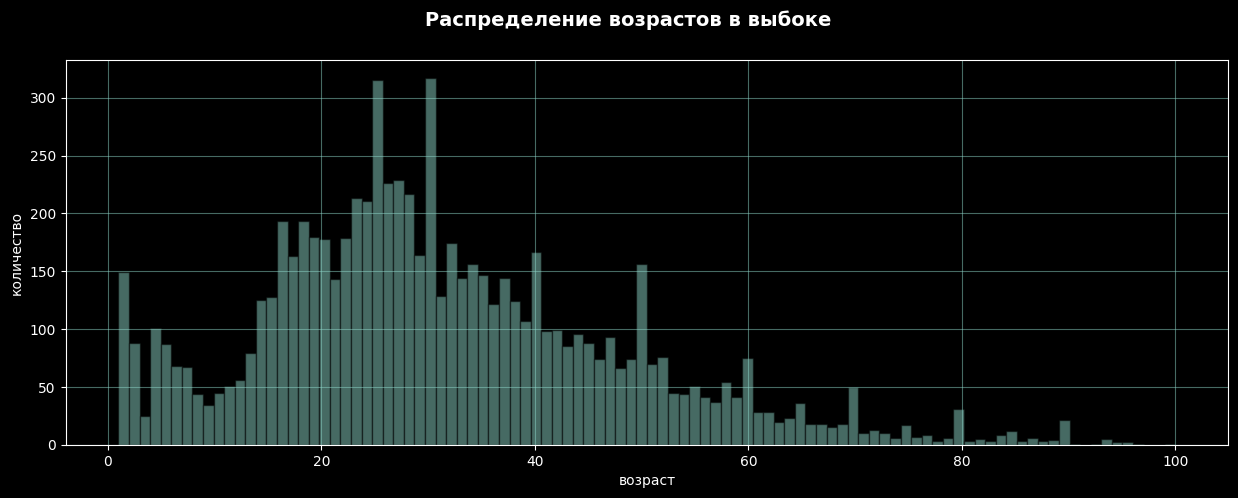

In [16]:
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot()
fig.subplots_adjust()
fig.suptitle('Распределение возрастов в выбоке', fontsize=14, fontweight='bold')
ax.set_xlabel('возраст')
ax.set_ylabel('количество')
plt.grid(color=(0.55, 0.83, 0.78), alpha=0.5)
plt.hist(df_full['real_age'],color=(0.55, 0.83, 0.78), alpha=0.5, edgecolor = 'black', bins = 100)
plt.show();

In [17]:
df_full.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [18]:
datagen = ImageDataGenerator(rescale=1./255)

gen_flow = datagen.flow_from_dataframe(
        dataframe=df_full,
        x_col='file_path',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=1337)

features, target = next(gen_flow)

Found 7591 validated image filenames.


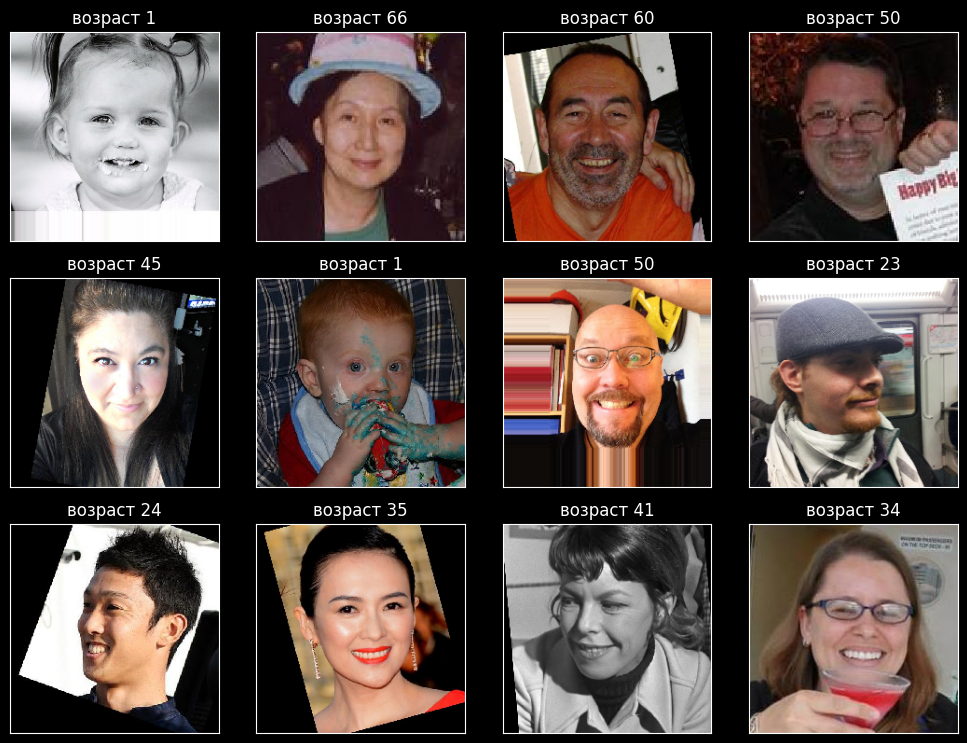

In [19]:
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title('возраст ' + str(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод по анализу данных

- загружен датасет из 7591 фотографии лиц с размеченым возрастом. Этого количества достаточно для построения модели
- большинство лиц в датасете принадлежат людям с возрастом около 30 лет (29 по медиане и около 31 среднее)
- минимальный и максимальный возроста 1 год и 100 лет
- лица на фото отцентрованы и приведены к похожим размерам, глаза находятся по центры по горизонтали и в верхней трети по вертикали
- по обрезанным и повернутым краям видно что фотографии предобрабатывали
- из аугментации подойдёт отражение по горизонтали так как лица симетричны по горизонтали и отраженное фото останется естественным
- не подойдут: отражение по вертикали так как это перевернёт лицо и сделает фото не естественным; сдвиги и повороты так как сильно будут выбивать фото из формата к которому их подогнали и добавят ещё больше чёрных областей на тех фото где они уже есть

# Обучение модели

### Создадим тренировочную выборку

In [20]:
datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255,
    horizontal_flip=True
    )

In [21]:
train_gen_flow = datagen.flow_from_dataframe(
    dataframe=df_full,
    x_col='file_path',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    subset='training',
    seed=1337)

Found 5694 validated image filenames.


### Создадим тестовую выборку

In [22]:
test_datagen_flow = datagen.flow_from_dataframe(
    dataframe=df_full,
    x_col='file_path',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    subset='validation',
    seed=1337)

Found 1897 validated image filenames.


### Определим размерность изображения

In [23]:
image = Image.open(df_full['file_path'][0])

if len(np.array(image).shape) == 3:
    channels = np.array(image).shape[2]
else:
    channels = 1

input_shape = (image.size[0], image.size[1], channels)

print(input_shape)

(114, 114, 3)


In [24]:
backbone = ResNet50(
    input_shape=input_shape,
    weights='imagenet',
    include_top=False) 
model = Sequential()
model.add(backbone)
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='relu'))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) 
model.fit(
    train_gen_flow,
    validation_data=test_datagen_flow,
    batch_size=16,
    epochs=10,
    steps_per_epoch=len(train_gen_flow),
    validation_steps=len(test_datagen_flow),
    shuffle=True,
    verbose=2)

Epoch 1/10
356/356 - 171s - loss: 229.3934 - mae: 10.8441 - val_loss: 616.6444 - val_mae: 19.7893 - 171s/epoch - 481ms/step
Epoch 2/10
356/356 - 82s - loss: 90.4531 - mae: 7.2506 - val_loss: 138.3178 - val_mae: 9.3257 - 82s/epoch - 230ms/step
Epoch 3/10
356/356 - 86s - loss: 64.7000 - mae: 6.1091 - val_loss: 85.6332 - val_mae: 6.8833 - 86s/epoch - 242ms/step
Epoch 4/10
356/356 - 86s - loss: 51.1973 - mae: 5.4531 - val_loss: 74.3945 - val_mae: 6.3964 - 86s/epoch - 241ms/step
Epoch 5/10
356/356 - 86s - loss: 36.5011 - mae: 4.6250 - val_loss: 104.5848 - val_mae: 7.9641 - 86s/epoch - 242ms/step
Epoch 6/10
356/356 - 88s - loss: 31.2079 - mae: 4.2663 - val_loss: 88.4751 - val_mae: 6.8481 - 88s/epoch - 247ms/step
Epoch 7/10
356/356 - 86s - loss: 27.0945 - mae: 3.9768 - val_loss: 73.9300 - val_mae: 6.5667 - 86s/epoch - 243ms/step
Epoch 8/10
356/356 - 86s - loss: 22.5216 - mae: 3.6079 - val_loss: 78.3364 - val_mae: 6.5127 - 86s/epoch - 243ms/step
Epoch 9/10
356/356 - 87s - loss: 19.3580 - mae: 

In [25]:
test_loss, test_mae = model.evaluate(test_datagen_flow, steps=len(test_datagen_flow), verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

119/119 - 9s - loss: 86.3710 - mae: 7.2288 - 9s/epoch - 73ms/step
Test Loss: 86.37095642089844
Test MAE: 7.228752136230469


Код для использования модели в будущем

In [ ]:
# model.save('saved_model/my_model')

# from tensorflow.keras.models import load_model
# model = load_model('saved_model/my_model')

## Анализ обученной модели

Для обущения модели произведена аугментация с отражением по горизонтали, яркость приведена к диапозону [0,1]
За основу взят бэкбон предобученной модели ResNet50, заморозка не производилась так как фотографий в выборке достаточно.
размер батча 16 фотографий, оптимизатор Adam с шагом 0.0001, функция потерь MSE.

Исходя из того что на тренировочной выборке метрики лучше чем на тестовой (например на 10 эпохе МАЕ составляет 3.2091 на тренировочной и 7.2288 на тестовой), можно сделать вывод что модель переобучилась, но это нормально для таких моделей

Модель достигла требуемого значения MAE (менее 8 за 10 эпох). но достаточного качества можно было бы достигнуть за меньшее количество эпох, тем самым сделав модель быстрее.

- Итоговоая метрика MAE составила 7.2288 